## Import Statements

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor


## Read in Data

In [2]:
df = pd.read_csv('../../data/preprocessed_repair_data.csv')
df = df[df['Label'] == 1];
df.drop(columns=['Label', 'Distance', 'Months', 'Odometer'], inplace=True)
df.head()

,TaskName,Make,Model,Year,FuelType,EngineSize,Transmission,DriveType,IsHybrid,AdjustedPrice
0,Park Light Globe Replacement,HYUNDAI,HYUNDAI TUCSON,2019,Diesel,2.0,Auto,4WD,0.0,7.0
1,Roadworthy Inspection / Pink Slips,VOLKSWAGEN,VOLKSWAGEN TIGUAN,2018,Petrol,2.0,Auto,4WD,0.0,46.0
2,Replace Wiper Blades,VOLKSWAGEN,VOLKSWAGEN TIGUAN,2018,Petrol,2.0,Auto,4WD,0.0,29.0
3,Rear Brake Pad And Rotor Replacement,VOLKSWAGEN,VOLKSWAGEN TIGUAN,2018,Petrol,2.0,Auto,4WD,0.0,725.0
5,Replace Wiper Blades,KIA,KIA SELTOS,2020,Petrol,1.6,Auto,4WD,0.0,46.0


In [3]:
X = df.drop(columns=["AdjustedPrice"])  
y = df["AdjustedPrice"]       

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
# Identify feature types
cat_features = X_train.select_dtypes(include=["object", "category"]).columns

In [6]:
for col in X_train.select_dtypes(include='object').columns:
     X_train[col] = X_train[col].fillna("missing")

for col in X_test.select_dtypes(include='object').columns:
   X_test[col] = X_test[col].fillna("missing")

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [8]:

cat_feature_indices = [0, 1, 2, 4, 6, 7]
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'iterations': [1000, 1500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20]
}

model = CatBoostRegressor(
    cat_features=cat_feature_indices,
    eval_metric='MAPE',
    od_type='Iter',
    od_wait=50,
    random_seed=42,
    verbose=100
)

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=25, cv=3, scoring='neg_mean_absolute_percentage_error')

random_search.fit(X_train, y_train, 
                  verbose=False)

best_model = random_search.best_estimator_

print("Best params:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

Best params: {'subsample': 0.9, 'min_child_samples': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 1500, 'depth': 10, 'colsample_bylevel': 1.0}
Best score: 4283652980967.7563


In [9]:


from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")


0:	learn: 2.9318115	total: 51.3ms	remaining: 1m 16s
100:	learn: 0.9094934	total: 5.98s	remaining: 1m 22s
200:	learn: 0.8589266	total: 12.3s	remaining: 1m 19s
300:	learn: 0.8446935	total: 18.4s	remaining: 1m 13s
400:	learn: 0.8391583	total: 24s	remaining: 1m 5s
500:	learn: 0.8320309	total: 31s	remaining: 1m 1s
600:	learn: 0.8266636	total: 38.1s	remaining: 57s
700:	learn: 0.8207537	total: 45.1s	remaining: 51.4s
800:	learn: 0.8163802	total: 52.3s	remaining: 45.6s
900:	learn: 0.8124706	total: 59.7s	remaining: 39.7s
1000:	learn: 0.8081842	total: 1m 6s	remaining: 33.4s
1100:	learn: 0.8057335	total: 1m 14s	remaining: 26.9s
1200:	learn: 0.8042610	total: 1m 20s	remaining: 20.1s
1300:	learn: 0.8018536	total: 1m 26s	remaining: 13.3s
1400:	learn: 0.8000327	total: 1m 33s	remaining: 6.62s
1499:	learn: 0.7973399	total: 1m 40s	remaining: 0us
MAE: 155.14731282803797
RMSE: 487.0372432682987
MAPE: 74.79%


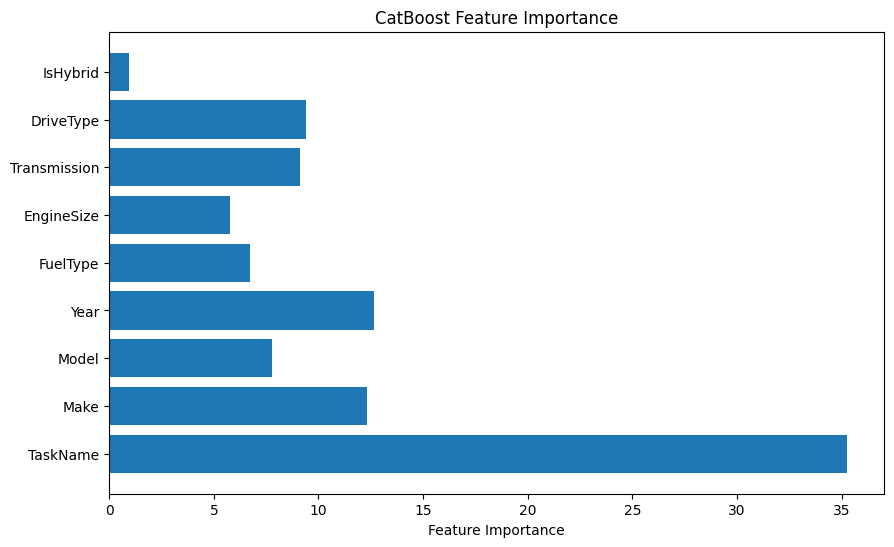

In [10]:
importance = best_model.get_feature_importance()
feature_names = X_train.columns  # or your list of feature names

plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()